# **NYC Taxi Fare Prediction**

### Imports and loading

In [1]:
# Imports

# Packages for numerics + dataframes

import pandas as pd
import numpy as np

# Packages for visualization

import matplotlib.pyplot as plt
import seaborn as sns

# Packages for date conversions for calculating trip durations

from datetime import datetime
from datetime import date
from datetime import timedelta

# Packages for OLS, MLR, confusion matrix

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics # For confusion matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

In [2]:
taxi = pd.read_csv("2017_Yellow_Taxi_Trip_Data.csv") 

### Exploratory Data Analysis

In [3]:
# Keep `taxi` as the original dataframe and create a copy (df) where changes will go
# Can revert `df` to `taxi` if needed down the line

df = taxi.copy()

# Display the dataset's shape

print(df.shape)

# Display basic info about the dataset

df.info()

(22699, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             22699 non-null  int64  
 1   VendorID               22699 non-null  int64  
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  int64  
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  int64  
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  int64  
 9   DOLocationID           22699 non-null  int64  
 10  payment_type           22699 non-null  int64  
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount             22699 non-null  flo

In [4]:
# Check for duplicates

print('Shape of dataframe:', df.shape)
print('Shape of dataframe with duplicates dropped:', df.drop_duplicates().shape)

# Check for missing values in dataframe

print('Total count of missing values:', df.isna().sum().sum())

# Display missing values per column in dataframe

print('Missing values per column:')
df.isna().sum()

Shape of dataframe: (22699, 18)
Shape of dataframe with duplicates dropped: (22699, 18)
Total count of missing values: 0
Missing values per column:


Unnamed: 0               0
VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
dtype: int64

There are no duplicates or missing values in the data.

In [5]:
# Display descriptive stats about the data

df.describe()

,Unnamed: 0,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,2.269900e+04,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000
mean,5.675849e+07,1.556236,1.642319,2.913313,1.043394,162.412353,161.527997,1.336887,13.026629,0.333275,0.497445,1.835781,0.312542,0.299551,16.310502
std,3.274493e+07,0.496838,1.285231,3.653171,0.708391,66.633373,70.139691,0.496211,13.243791,0.463097,0.039465,2.800626,1.399212,0.015673,16.097295
min,1.212700e+04,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-120.000000,-1.000000,-0.500000,0.000000,0.000000,-0.300000,-120.300000
25%,2.852056e+07,1.000000,1.000000,0.990000,1.000000,114.000000,112.000000,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,8.750000
50%,5.673150e+07,2.000000,1.000000,1.610000,1.000000,162.000000,162.000000,1.000000,9.500000,0.000000,0.500000,1.350000,0.000000,0.300000,11.800000
75%,8.537452e+07,2.000000,2.000000,3.060000,1.000000,233.000000,233.000000,2.000000,14.500000,0.500000,0.500000,2.450000,0.000000,0.300000,17.800000
max,1.134863e+08,2.000000,6.000000,33.960000,99.000000,265.000000,265.000000,4.000000,999.990000,4.500000,0.500000,200.000000,19.100000,0.300000,1200.290000


Some things stand out from this table of summary statistics. For instance, there are clearly some outliers in several variables, like `tip_amount` (\$200) and `total_amount` (\$1,200). Also, a number of the variables, such as `mta_tax`, seem to be almost constant throughout the data, which would imply that they would not be expected to be very predictive.

In [6]:
# Check the format of the data

df['tpep_dropoff_datetime'][0]

'03/25/2017 9:09:47 AM'

In [7]:
# Convert datetime columns to datetime
# Display data types of `tpep_pickup_datetime`, `tpep_dropoff_datetime`

print('Data type of tpep_pickup_datetime:', df['tpep_pickup_datetime'].dtype)
print('Data type of tpep_dropoff_datetime:', df['tpep_dropoff_datetime'].dtype)

# Convert `tpep_pickup_datetime` to datetime format

df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'], format='%m/%d/%Y %I:%M:%S %p')

# Convert `tpep_dropoff_datetime` to datetime format

df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'], format='%m/%d/%Y %I:%M:%S %p')

# Display data types of `tpep_pickup_datetime`, `tpep_dropoff_datetime`

print('Data type of tpep_pickup_datetime:', df['tpep_pickup_datetime'].dtype)
print('Data type of tpep_dropoff_datetime:', df['tpep_dropoff_datetime'].dtype)

df.head(3)

Data type of tpep_pickup_datetime: object
Data type of tpep_dropoff_datetime: object
Data type of tpep_pickup_datetime: datetime64[ns]
Data type of tpep_dropoff_datetime: datetime64[ns]


,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75


In [8]:
# Create `duration` column

df['duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime'])/np.timedelta64(1,'m')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             22699 non-null  int64         
 1   VendorID               22699 non-null  int64         
 2   tpep_pickup_datetime   22699 non-null  datetime64[ns]
 3   tpep_dropoff_datetime  22699 non-null  datetime64[ns]
 4   passenger_count        22699 non-null  int64         
 5   trip_distance          22699 non-null  float64       
 6   RatecodeID             22699 non-null  int64         
 7   store_and_fwd_flag     22699 non-null  object        
 8   PULocationID           22699 non-null  int64         
 9   DOLocationID           22699 non-null  int64         
 10  payment_type           22699 non-null  int64         
 11  fare_amount            22699 non-null  float64       
 12  extra                  22699 non-null  float64       
 13  m

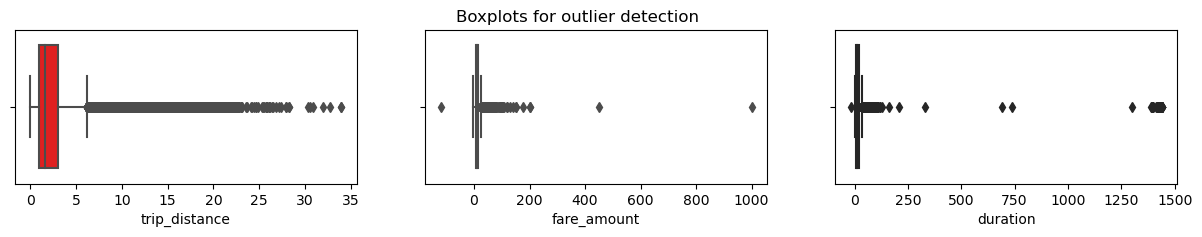

In [10]:
# Boxplots for 'trip_distance', 'fare_amount' and 'duration'.

fig, axes = plt.subplots(1, 3, figsize = (15, 2))
fig.suptitle('Boxplots for outlier detection')
sns.boxplot(ax = axes[0], x = df['trip_distance'], color = 'red')
sns.boxplot(ax = axes[1], x = df['fare_amount'], color = 'yellow')
sns.boxplot(ax = axes[2], x = df['duration'], color = 'green')
plt.show();

All three variables contain outliers. Some are extreme, but others not so much. The values for `fare_amount` and `duration` definitely seem to have problematic outliers on the higher end.

In [11]:
# Are trip distances of 0 bad data or very short trips rounded down?

sorted(set(df['trip_distance']))[:10]

[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]

The distances are captured with a high degree of precision. However, it might be possible for trips to have distances of zero if a passenger summoned a taxi and then changed their mind. Besides, are there enough zero values in the data to pose a problem?

Calculate the count of rides where the `trip_distance` is zero.

In [12]:
sum(df['trip_distance']==0)

148

148 out of ~23,000 rides is relatively insignificant. You could impute it with a value of 0.01, but it's unlikely to have much of an effect on the model. Therefore, the `trip_distance` column will remain untouched with regard to outliers.

#### `fare_amount` outliers

In [13]:
df['fare_amount'].describe()

count    22699.000000
mean        13.026629
std         13.243791
min       -120.000000
25%          6.500000
50%          9.500000
75%         14.500000
max        999.990000
Name: fare_amount, dtype: float64

The range of values in the `fare_amount` column is large and the extremes don't make much sense.

* **Low values:** Negative values are problematic. Values of zero could be legitimate if the taxi logged a trip that was immediately canceled.

* **High values:** The maximum fare amount in this dataset is nearly \$1,000, which seems very unlikely. High values for this feature can be capped based on intuition and statistics. The interquartile range (IQR) is \$8. The standard formula of `Q3 + (1.5 * IQR)` yields \$26.50. That doesn't seem appropriate for the maximum fare cap. In this case, we'll use a factor of `6`, which results in a cap of $62.50.

Impute values less than $0 with `0`.

In [14]:
# Impute values less than $0 with 0

df.loc[df['fare_amount'] < 0, 'fare_amount'] = 0
df['fare_amount'].min()

0.0

Now impute the maximum value as `Q3 + (6 * IQR)`.

In [15]:
def outlier_imputer(column_list, iqr_factor):
    '''
    Impute upper-limit values in specified columns based on their interquartile range.

    Arguments:
        column_list: A list of columns to iterate over
        iqr_factor: A number representing x in the formula:
                    Q3 + (x * IQR). Used to determine maximum threshold,
                    beyond which a point is considered an outlier.

    The IQR is computed for each column in column_list and values exceeding
    the upper threshold for each column are imputed with the upper threshold value.
    '''
    for col in column_list:
        # Reassign minimum to zero
        df.loc[df[col] < 0, col] = 0

        # Calculate upper threshold
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        upper_threshold = q3 + (iqr_factor * iqr)
        print(col)
        print('q3:', q3)
        print('upper_threshold:', upper_threshold)

        # Reassign values > threshold to threshold
        df.loc[df[col] > upper_threshold, col] = upper_threshold
        print(df[col].describe())
        print()

In [16]:
outlier_imputer(['fare_amount'], 6)

fare_amount
q3: 14.5
upper_threshold: 62.5
count    22699.000000
mean        12.897913
std         10.541137
min          0.000000
25%          6.500000
50%          9.500000
75%         14.500000
max         62.500000
Name: fare_amount, dtype: float64



#### `duration` outliers

In [17]:
df['duration'].describe()

count    22699.000000
mean        17.013777
std         61.996482
min        -16.983333
25%          6.650000
50%         11.183333
75%         18.383333
max       1439.550000
Name: duration, dtype: float64

The `duration` column has problematic values at both the lower and upper extremities.

* **Low values:** There should be no values that represent negative time. Impute all negative durations with `0`.

* **High values:** Impute high values the same way you imputed the high-end outliers for fares: `Q3 + (6 * IQR)`.

In [18]:
# Impute a 0 for any negative values

df.loc[df['duration'] < 0, 'duration'] = 0
df['duration'].min()

0.0

In [19]:
# Impute the high outliers

outlier_imputer(['duration'], 6)

duration
q3: 18.383333333333333
upper_threshold: 88.78333333333333
count    22699.000000
mean        14.460555
std         11.947043
min          0.000000
25%          6.650000
50%         11.183333
75%         18.383333
max         88.783333
Name: duration, dtype: float64



### Feature engineering

In [20]:
# Create `pickup_dropoff` column

df['pickup_dropoff'] = df['PULocationID'].astype(str) + ' ' + df['DOLocationID'].astype(str)
df['pickup_dropoff'].head(2)

0    100 231
1     186 43
Name: pickup_dropoff, dtype: object

In [21]:
grouped = df.groupby('pickup_dropoff').mean(numeric_only=True)[['trip_distance']]
grouped[:5]

,trip_distance
pickup_dropoff,
1 1,2.433333
10 148,15.700000
100 1,16.890000
100 100,0.253333
100 107,1.180000


In [22]:
# 1. Convert `grouped` to a dictionary

grouped_dict = grouped.to_dict()

# 2. Reassign to only contain the inner dictionary

grouped_dict = grouped_dict['trip_distance']

In [23]:
# 1. Create a mean_distance column that is a copy of the pickup_dropoff helper column

df['mean_distance'] = df['pickup_dropoff']

# 2. Map `grouped_dict` to the `mean_distance` column

df['mean_distance'] = df['mean_distance'].map(grouped_dict)

# Confirm that it worked

df[(df['PULocationID']==100) & (df['DOLocationID']==231)][['mean_distance']]

,mean_distance
0,3.521667
4909,3.521667
16636,3.521667
18134,3.521667
19761,3.521667
20581,3.521667


In [24]:
#  Create `mean_duration` column. Repeat the process used to create the `mean_distance` column to create 
# a `mean_duration` column.

grouped = df.groupby('pickup_dropoff').mean(numeric_only=True)[['duration']]
grouped

# Create a dictionary where keys are unique pickup_dropoffs and values are
# mean trip duration for all trips with those pickup_dropoff combos

grouped_dict = grouped.to_dict()
grouped_dict = grouped_dict['duration']

df['mean_duration'] = df['pickup_dropoff']
df['mean_duration'] = df['mean_duration'].map(grouped_dict)

# Confirm that it worked

df[(df['PULocationID']==100) & (df['DOLocationID']==231)][['mean_duration']]

,mean_duration
0,22.847222
4909,22.847222
16636,22.847222
18134,22.847222
19761,22.847222
20581,22.847222


In [25]:
# Create 'day' col

df['day'] = df['tpep_pickup_datetime'].dt.day_name().str.lower()

# Create 'month' col

df['month'] = df['tpep_pickup_datetime'].dt.strftime('%b').str.lower()

In [26]:
# Create 'rush_hour' col

df['rush_hour'] = df['tpep_pickup_datetime'].dt.hour

# If day is Saturday or Sunday, impute 0 in `rush_hour` column

df.loc[df['day'].isin(['saturday', 'sunday']), 'rush_hour'] = 0

In [27]:
def rush_hourizer(hour):
    if 6 <= hour['rush_hour'] < 10:
        val = 1
    elif 16 <= hour['rush_hour'] < 20:
        val = 1
    else:
        val = 0
    return val

In [28]:
# Apply the `rush_hourizer()` function to the new column

df['rush_hour'] = df.apply(rush_hourizer, axis=1)
df.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,tolls_amount,improvement_surcharge,total_amount,duration,pickup_dropoff,mean_distance,mean_duration,day,month,rush_hour
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,...,0.0,0.3,16.56,14.066667,100 231,3.521667,22.847222,saturday,mar,0
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,...,0.0,0.3,20.80,26.500000,186 43,3.108889,24.470370,tuesday,apr,0
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,...,0.0,0.3,8.75,7.200000,262 236,0.881429,7.250000,friday,dec,1
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,...,0.0,0.3,27.69,30.250000,188 97,3.700000,30.250000,sunday,may,0
4,30841670,2,2017-04-15 23:32:20,2017-04-15 23:49:03,1,4.37,1,N,4,112,...,0.0,0.3,17.80,16.716667,4 112,4.435000,14.616667,saturday,apr,0


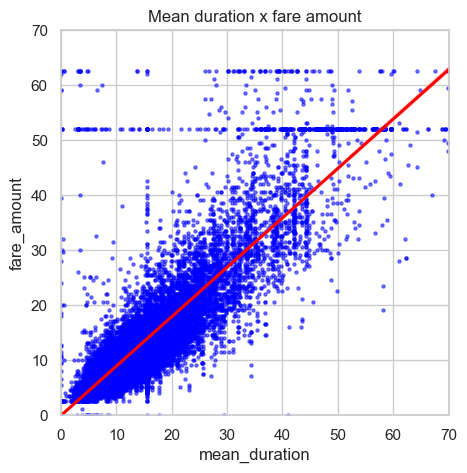

In [29]:
# Scatter plot of duration and trip_distance, with a line of best fit.

sns.set(style = 'whitegrid')
f = plt.figure()
f.set_figwidth(5)
f.set_figheight(5)
sns.regplot(x = df['mean_duration'], y = df['fare_amount'],
            scatter_kws = {'alpha':0.5, 's':5},
            line_kws = {'color':'red'}, color = 'blue')
plt.ylim(0, 70)
plt.xlim(0, 70)
plt.title('Mean duration x fare amount')
plt.show()

The `mean_duration` variable correlates with the target variable. But what are the horizontal lines around fare amounts of 52 dollars and 63 dollars? What are the values and how many are there?

You know what one of the lines represents. 62 dollars and 50 cents is the maximum that was imputed for outliers, so all former outliers will now have fare amounts of \$62.50. What is the other line?

Check the value of the rides in the second horizontal line in the scatter plot.

In [30]:
df[df['fare_amount'] > 50]['fare_amount'].value_counts().head()

52.0    514
62.5     84
59.0      9
50.5      9
57.5      8
Name: fare_amount, dtype: int64

There are 514 trips whose fares were \$52.

Examine the first 30 of these trips.

In [31]:
# Set pandas to display all columns

pd.set_option('display.max_columns', None)
df[df['fare_amount']==52].head(30)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration,pickup_dropoff,mean_distance,mean_duration,day,month,rush_hour
11,18600059,2,2017-03-05 19:15:30,2017-03-05 19:52:18,2,18.90,2,N,236,132,1,52.0,0.0,0.5,14.58,5.54,0.3,72.92,36.800000,236 132,19.211667,40.500000,sunday,mar,0
110,47959795,1,2017-06-03 14:24:57,2017-06-03 15:31:48,1,18.00,2,N,132,163,1,52.0,0.0,0.5,0.00,0.00,0.3,52.80,66.850000,132 163,19.229000,52.941667,saturday,jun,0
161,95729204,2,2017-11-11 20:16:16,2017-11-11 20:17:14,1,0.23,2,N,132,132,2,52.0,0.0,0.5,0.00,0.00,0.3,52.80,0.966667,132 132,2.255862,3.021839,saturday,nov,0
247,103404868,2,2017-12-06 23:37:08,2017-12-07 00:06:19,1,18.93,2,N,132,79,2,52.0,0.0,0.5,0.00,0.00,0.3,52.80,29.183333,132 79,19.431667,47.275000,wednesday,dec,0
379,80479432,2,2017-09-24 23:45:45,2017-09-25 00:15:14,1,17.99,2,N,132,234,1,52.0,0.0,0.5,14.64,5.76,0.3,73.20,29.483333,132 234,17.654000,49.833333,sunday,sep,0
388,16226157,1,2017-02-28 18:30:05,2017-02-28 19:09:55,1,18.40,2,N,132,48,2,52.0,4.5,0.5,0.00,5.54,0.3,62.84,39.833333,132 48,18.761905,58.246032,tuesday,feb,1
406,55253442,2,2017-06-05 12:51:58,2017-06-05 13:07:35,1,4.73,2,N,228,88,2,52.0,0.0,0.5,0.00,5.76,0.3,58.56,15.616667,228 88,4.730000,15.616667,monday,jun,0
449,65900029,2,2017-08-03 22:47:14,2017-08-03 23:32:41,2,18.21,2,N,132,48,2,52.0,0.0,0.5,0.00,5.76,0.3,58.56,45.450000,132 48,18.761905,58.246032,thursday,aug,0
468,80904240,2,2017-09-26 13:48:26,2017-09-26 14:31:17,1,17.27,2,N,186,132,2,52.0,0.0,0.5,0.00,5.76,0.3,58.56,42.850000,186 132,17.096000,42.920000,tuesday,sep,0
520,33706214,2,2017-04-23 21:34:48,2017-04-23 22:46:23,6,18.34,2,N,132,148,1,52.0,0.0,0.5,5.00,0.00,0.3,57.80,71.583333,132 148,17.994286,46.340476,sunday,apr,0


It seems that almost all of the trips in the first 30 rows where the fare amount was \$52 either begin or end at location 132, and all of them have a `RatecodeID` of 2.

There is no readily apparent reason why PULocation 132 should have so many fares of 52 dollars. They seem to occur on all different days, at different times, with both vendors, in all months. However, there are many toll amounts of $5.76 and \\$5.54. This would seem to indicate that location 132 is in an area that frequently requires tolls to get to and from. It's likely this is an airport.


The data dictionary says that `RatecodeID` of 2 indicates trips for JFK, which is John F. Kennedy International Airport. A quick Google search for "new york city taxi flat rate \$52" indicates that in 2017 (the year that this data was collected) there was indeed a flat fare for taxi trips between JFK airport (in Queens) and Manhattan.

Because `RatecodeID` is known from the data dictionary, the values for this rate code can be imputed back into the data after the model makes its predictions. This way you know that those data points will always be correct.

###  Isolate modeling variables

Drop features that are redundant, irrelevant, or that will not be available in a deployed environment.

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             22699 non-null  int64         
 1   VendorID               22699 non-null  int64         
 2   tpep_pickup_datetime   22699 non-null  datetime64[ns]
 3   tpep_dropoff_datetime  22699 non-null  datetime64[ns]
 4   passenger_count        22699 non-null  int64         
 5   trip_distance          22699 non-null  float64       
 6   RatecodeID             22699 non-null  int64         
 7   store_and_fwd_flag     22699 non-null  object        
 8   PULocationID           22699 non-null  int64         
 9   DOLocationID           22699 non-null  int64         
 10  payment_type           22699 non-null  int64         
 11  fare_amount            22699 non-null  float64       
 12  extra                  22699 non-null  float64       
 13  m

In [33]:
df2 = df.copy()

df2 = df2.drop(['Unnamed: 0', 'tpep_dropoff_datetime', 'tpep_pickup_datetime',
               'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID',
               'payment_type', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
               'total_amount', 'tpep_dropoff_datetime', 'tpep_pickup_datetime', 'duration',
               'pickup_dropoff', 'day', 'month'
               ], axis=1)

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VendorID         22699 non-null  int64  
 1   passenger_count  22699 non-null  int64  
 2   fare_amount      22699 non-null  float64
 3   mean_distance    22699 non-null  float64
 4   mean_duration    22699 non-null  float64
 5   rush_hour        22699 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 1.0 MB


### Pair plot

Create a pairplot to visualize pairwise relationships between `fare_amount`, `mean_duration`, and `mean_distance`.

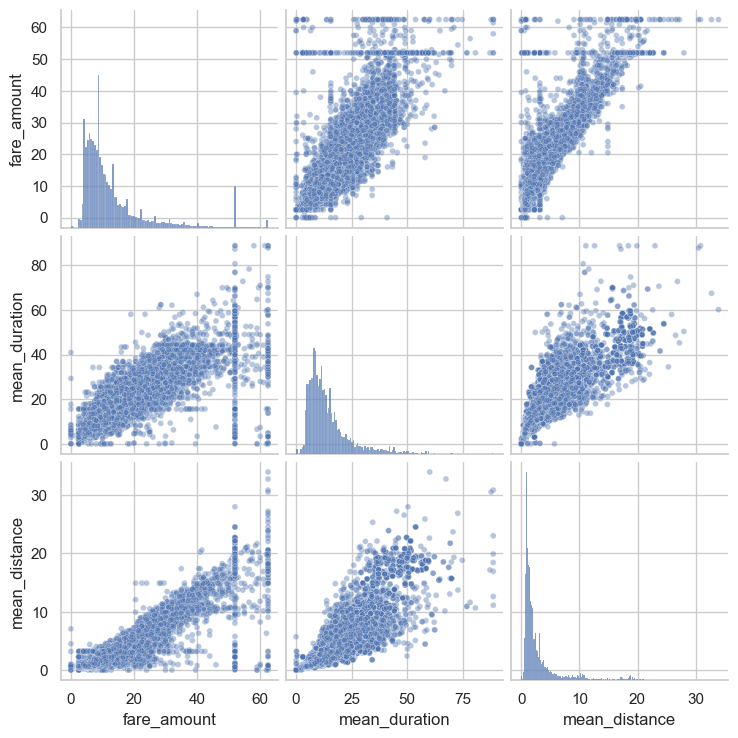

In [34]:
# Create a pairplot to visualize pairwise relationships between variables in the data

sns.pairplot(df2[['fare_amount', 'mean_duration', 'mean_distance']],
             plot_kws={'alpha':0.4, 'size':5},
             );

These variables all show linear correlation with each other. 

### Identify correlations

In [35]:
# Create correlation matrix containing pairwise correlation of columns, using pearson correlation coefficient
df2.corr(method = 'pearson')

,VendorID,passenger_count,fare_amount,mean_distance,mean_duration,rush_hour
VendorID,1.000000,0.266463,0.001045,0.004741,0.001876,-0.002874
passenger_count,0.266463,1.000000,0.014942,0.013428,0.015852,-0.022035
fare_amount,0.001045,0.014942,1.000000,0.910185,0.859105,-0.020075
mean_distance,0.004741,0.013428,0.910185,1.000000,0.874864,-0.039725
mean_duration,0.001876,0.015852,0.859105,0.874864,1.000000,-0.021583
rush_hour,-0.002874,-0.022035,-0.020075,-0.039725,-0.021583,1.000000


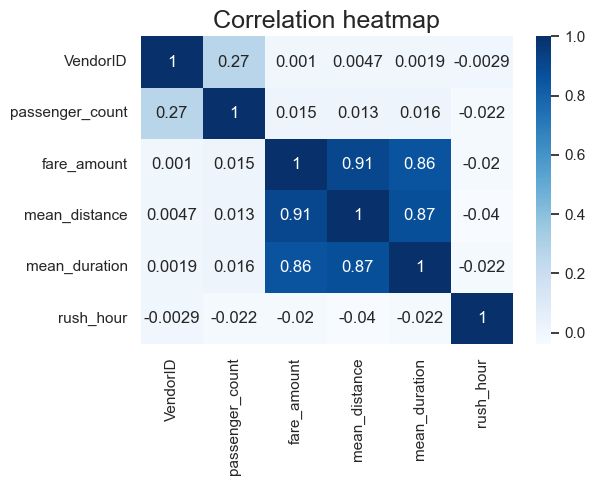

In [36]:
# Create correlation heatmap

plt.figure(figsize = (6,4))
sns.heatmap(df2.corr(method = 'pearson'), annot = True, cmap = 'Blues')
plt.title('Correlation heatmap',
          fontsize = 18)
plt.show()

`mean_duration` and `mean_distance` are both highly correlated with the target variable of `fare_amount` They're also both correlated with each other, with a Pearson correlation of 0.87.

Recall that highly correlated predictor variables can be bad for linear regression models when you want to be able to draw statistical inferences about the data from the model. However, correlated predictor variables can still be used to create an accurate predictor if the prediction itself is more important than using the model as a tool to learn about your data.

This model will predict `fare_amount`, which will be used as a predictor variable in machine learning models. Therefore, try modeling with both variables even though they are correlated.

### Split data into outcome variable and features

In [37]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VendorID         22699 non-null  int64  
 1   passenger_count  22699 non-null  int64  
 2   fare_amount      22699 non-null  float64
 3   mean_distance    22699 non-null  float64
 4   mean_duration    22699 non-null  float64
 5   rush_hour        22699 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 1.0 MB


Set your X and y variables. X represents the features and y represents the outcome (target) variable.

In [38]:
# Remove the target column from the features
X = df2.drop(columns=['fare_amount'])

# Set y variable
y = df2[['fare_amount']]

# Display first few rows
X.head()

,VendorID,passenger_count,mean_distance,mean_duration,rush_hour
0,2,6,3.521667,22.847222,0
1,1,1,3.108889,24.470370,0
2,1,1,0.881429,7.250000,1
3,2,1,3.700000,30.250000,0
4,2,1,4.435000,14.616667,0


### Pre-process data

Dummy encode categorical variables

In [39]:
# Convert VendorID to string
X['VendorID'] = X['VendorID'].astype(str)

# Get dummies
X = pd.get_dummies(X, drop_first=True)
X.head()

,passenger_count,mean_distance,mean_duration,rush_hour,VendorID_2
0,6,3.521667,22.847222,0,1
1,1,3.108889,24.470370,0,0
2,1,0.881429,7.250000,1,0
3,1,3.700000,30.250000,0,1
4,1,4.435000,14.616667,0,1


### Split data into training and test sets

Create training and testing sets. The test set should contain 20% of the total samples. Set `random_state=0`.

In [40]:
# Create training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Standardize the data

Use `StandardScaler()`, `fit()`, and `transform()` to standardize the `X_train` variables. Assign the results to a variable called `X_train_scaled`.

In [41]:
# Standardize the X variables
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
print('X_train scaled:', X_train_scaled)

X_train scaled: [[-0.50301524  0.8694684   0.17616665 -0.64893329  0.89286563]
 [-0.50301524 -0.60011281 -0.69829589  1.54099045  0.89286563]
 [ 0.27331093 -0.47829156 -0.57301906 -0.64893329 -1.11998936]
 ...
 [-0.50301524 -0.45121122 -0.6788917  -0.64893329 -1.11998936]
 [-0.50301524 -0.58944763 -0.85743597  1.54099045 -1.11998936]
 [ 1.82596329  0.83673851  1.13212101 -0.64893329  0.89286563]]


### Fit the model

Instantiate your model and fit it to the training data.

In [42]:
# Fit your model to the training data
lr=LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression()

### Evaluate model

### Train data

Evaluate your model performance by calculating the residual sum of squares and the explained variance score (R^2). Calculate the Mean Absolute Error, Mean Squared Error, and the Root Mean Squared Error.

In [43]:
# Evaluate the model performance on the training data
r_sq = lr.score(X_train_scaled, y_train)
print('Coefficient of determination:', r_sq)
y_pred_train = lr.predict(X_train_scaled)
print('R^2:', r2_score(y_train, y_pred_train))
print('MAE:', mean_absolute_error(y_train, y_pred_train))
print('MSE:', mean_squared_error(y_train, y_pred_train))
print('RMSE:',np.sqrt(mean_squared_error(y_train, y_pred_train)))

Coefficient of determination: 0.8398434585044774
R^2: 0.8398434585044774
MAE: 2.1866664167754157
MSE: 17.889732963492676
RMSE: 4.229625629236313


### Test data

Calculate the same metrics on the test data. Remember to scale the `X_test` data using the scaler that was fit to the training data. Do not refit the scaler to the testing data, just transform it. Call the results `X_test_scaled`.

In [44]:
# Scale the X_test data

X_test_scaled = scaler.transform(X_test)

In [45]:
# Evaluate the model performance on the testing data

r_sq_test = lr.score(X_test_scaled, y_test)
print('Coefficient of determination:', r_sq_test)
y_pred_test = lr.predict(X_test_scaled)
print('R^2:', r2_score(y_test, y_pred_test))
print('MAE:', mean_absolute_error(y_test,y_pred_test))
print('MSE:', mean_squared_error(y_test, y_pred_test))
print('RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_test)))

Coefficient of determination: 0.8682583641795454
R^2: 0.8682583641795454
MAE: 2.1336549840593886
MSE: 14.326454156998949
RMSE: 3.7850302716093234


The model performance is high on both training and test sets, suggesting that there is no bias in the model and that the model is not overfit. In fact, the test scores were somewhat better.

For the test data, an R<sup>2</sup> of 0.868 means that 86.8% of the variance in the `fare_amount` variable is described by the model.

The mean absolute error is informative here because, for the purposes of the model, an error of two is not more than twice as bad as an error of one.

### Results

In [46]:
# Create a `results` dataframe

results = pd.DataFrame(data={'actual': y_test['fare_amount'],
                             'predicted': y_pred_test.ravel()})
results['residual'] = results['actual'] - results['predicted']
results.head()

,actual,predicted,residual
5818,14.0,12.356503,1.643497
18134,28.0,16.314595,11.685405
4655,5.5,6.726789,-1.226789
7378,15.5,16.227206,-0.727206
13914,9.5,10.536408,-1.036408


### Visualize model results

Create a scatterplot to visualize `actual` vs. `predicted`.

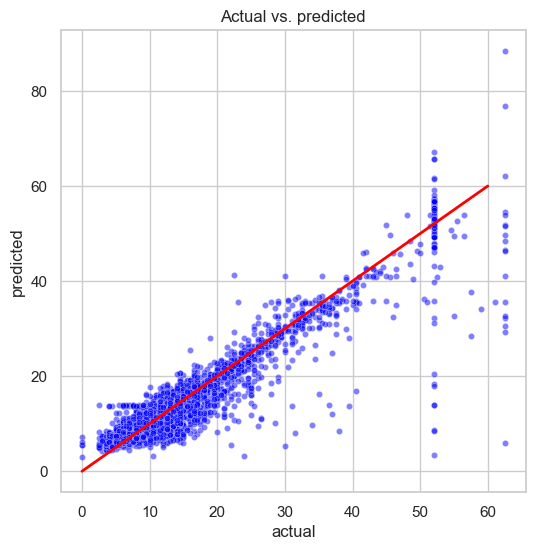

In [47]:
# Create a scatterplot to visualize `predicted` over `actual`

fig, ax = plt.subplots(figsize=(6, 6))
sns.set(style='whitegrid')
sns.scatterplot(x='actual',
                y='predicted',
                data=results,
                s=20,
                alpha=0.5,
                ax=ax,
                color='blue'
)
plt.plot([0,60], [0,60], c='red', linewidth=2)
plt.title('Actual vs. predicted');

Visualize the distribution of the `residuals` using a histogram

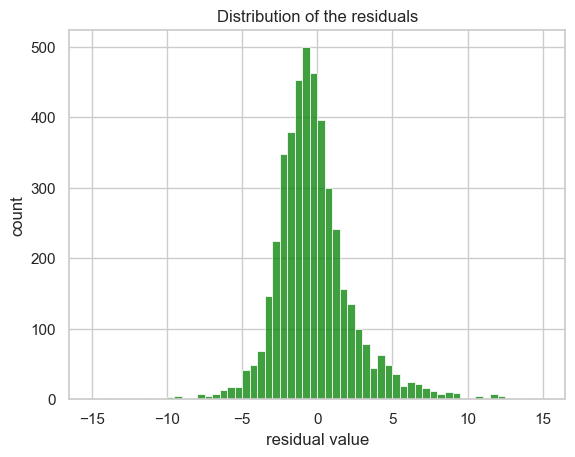

In [48]:
# Visualize the distribution of the `residuals`

sns.histplot(results['residual'], bins=np.arange(-15,15.5,0.5), color = 'green')
plt.title('Distribution of the residuals')
plt.xlabel('residual value')
plt.ylabel('count');

In [49]:
results['residual'].mean()

-0.015442621528680546

The distribution of the residuals is normal and has a mean of -0.015. The residuals represent the variance in the outcome variable that is not explained by the model. A normal distribution around zero is good, as it demonstrates that the models errors are evenly distributed and unbiased.

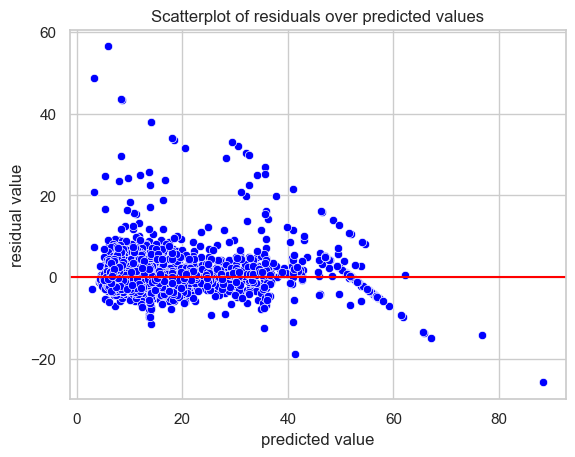

In [50]:
# Create a scatterplot of `residuals` over `predicted`

sns.scatterplot(x='predicted', y='residual', data=results, color = 'blue')
plt.axhline(0, c='red')
plt.title('Scatterplot of residuals over predicted values')
plt.xlabel('predicted value')
plt.ylabel('residual value')
plt.show()

The model's residuals are evenly distributed above and below zero, with the exception of the sloping lines from the upper-left corner to the lower-right corner, which you know are the imputed maximum of \\$62.50 and the flat rate of \\$52 for JFK airport trips.

### Coefficients

In [51]:
# Get model coefficients

coefficients = pd.DataFrame(lr.coef_, columns=X.columns)
coefficients

,passenger_count,mean_distance,mean_duration,rush_hour,VendorID_2
0,0.030825,7.133867,2.812115,0.110233,-0.054373


The coefficients reveal that `mean_distance` was the feature with the greatest weight in the model's final prediction. *For every +1 change in standard deviation*, the fare amount increases by a mean of \\$7.13. 

Note also that because some highly correlated features were not removed, the confidence interval of this assessment is wider.

So, translate this back to miles instead of standard deviation (i.e., unscale the data). 

1. Calculate the standard deviation of `mean_distance` in the `X_train` data.

2. Divide the coefficient (7.133867) by the result to yield a more intuitive interpretation.

In [52]:
# 1. Calculate SD of `mean_distance` in X_train data

print(X_train['mean_distance'].std())

# 2. Divide the model coefficient by the standard deviation

print(7.133867 / X_train['mean_distance'].std())

3.574812975256415
1.9955916713344426


Intuitive interpretation: for every 3.57 miles traveled, the fare increased by a mean of \\$7.13. Or, reduced: for every 1 mile traveled, the fare increased by a mean of \\$2.00.